In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3
import chess
import graphviz
import chess.polyglot

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
model = Model()
# model = torch.load("tiny.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [7]:
def fen_to_bitboard(fen):
    f = torch.zeros((6, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        a = 1
        b = -1
    if board.turn == chess.BLACK:
        a = -1
        b = 1
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = a
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = a
    f[2][list(board.pieces(chess.ROOK, chess.WHITE))] = a
    f[3][list(board.pieces(chess.BISHOP, chess.WHITE))] = a
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = a
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = a
    
    f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = b
    f[1][list(board.pieces(chess.KNIGHT, chess.BLACK))] = b
    f[2][list(board.pieces(chess.ROOK, chess.BLACK))] = b
    f[3][list(board.pieces(chess.BISHOP, chess.BLACK))] = b
    f[4][list(board.pieces(chess.QUEEN, chess.BLACK))] = b
    f[5][list(board.pieces(chess.KING, chess.BLACK))] = b
    
    return f.view(1, 384)

In [3]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [9]:
def fen_to_zobrist(fen):
    f = torch.zeros(1, 64)
    board = chess.Board(fen)
    for i, val in enumerate(list('{0:0b}'.format(chess.polyglot.zobrist_hash(board)))):
        if val == "1":
            f[0][i] = 1
    return f

In [12]:
size = 1000000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
fens = fens_.fetchall()
board = chess.Board()
tensors = []
tensors = [fen_to_zobrist(fens[i][0]) for i in range(size)]
bits = torch.cat(tensors, dim=0)
with open('johnZobrist.npy', 'wb') as f:
    np.save(f, bits)

# evals_ = cur.execute(f"SELECT eval FROM evaluations LIMIT {size}")
# evals = evals_.fetchall()
# temp = [((np.arctan(1/2 * evals[i][0]) + np.pi/2)/(np.pi)) for i in range(size)]
# evaluations = torch.tensor(temp, dtype=torch.float32)
# with open('labels.npy', 'wb') as f:
#     np.save(f, evaluations)


# evaluation dataset
# eval_size = 10000
# e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# e_fen = e_fen_.fetchall()
# tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
# bits = torch.cat(tensors, dim=0)
# with open('eval_examples.npy', 'wb') as f:
#     np.save(f, bits)

# evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
# evaluations = torch.tensor(temp)
# with open('eval_labels.npy', 'wb') as f:
#     np.save(f, evaluations)

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=100, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-2, 2), xticks=np.arange(1, 1),
#        ylim=(0, 1000), yticks=np.linspace(0, 1000, 9))

# plt.show()

In [5]:
losses = []
# eval_losses = []

bits = torch.from_numpy(np.load("johnZobrist.npy")).to(device)
labels = torch.from_numpy(np.load("labels.npy")).to(device)

# eval_examples = torch.from_numpy(np.load("eval_examples.npy")).to(device)
# eval_labels = torch.from_numpy(np.load("eval_labels.npy")).to(device)

In [6]:
# model training
# https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
n_epochs = 100 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
#     eval_permutation = torch.randperm(bits.size()[0])
#     for i in range(0, eval_examples.size()[0], batch_size):
#         indices = eval_permutation[i:i+batch_size]
#         batch_x, batch_y = bits[indices], labels[indices]
#         outputs = model(batch_x)
        
#         loss = loss_function(outputs, batch_y.view(-1, 1))
#         eval_losses.append(loss.item())
        
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

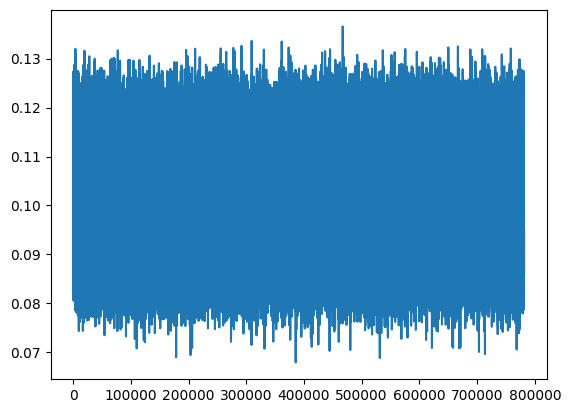

In [7]:
start = 100
smooth = 1

x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

# e_x = np.arange(0, (len(eval_losses)/smooth) * 100, 100)
# e_y = torch.tensor(eval_losses).view(smooth, -1).mean(0)
# plt.plot(e_x[int(start/100):], e_y[int(start/100):])

# plt.ylim(0, 0.005)
plt.show()

In [8]:
sum(losses[len(losses) - 100:]) / 100

0.10188327915966511

In [124]:
fen = "8/8/8/KP1q1k2/P7/8/8/8 w - - 1 61"
a = fen_to_bitboard(fen)
# print(model(a))
w = list(model.parameters())[0][0]
b = torch.tensor([0.5235], device=device)
w1 = (torch.floor((w*90.2425267908)+6.7241))
# relu = torch.nn.ReLU()
L = []
for i in w1.int():
    L.append(i.item())
print(L)
# print(a @ w)
# print(((a @ w1) - (6.7241 * torch.sum(a)))/90.2425267908)

[4, 3, 6, 4, 8, 8, 4, 6, 7, 6, 6, 7, 6, 6, 6, 6, 7, 6, 5, 6, 7, 7, 6, 6, 7, 7, 6, 7, 6, 5, 6, 7, 8, 7, 5, 7, 6, 7, 9, 6, 6, 5, 6, 4, 4, 4, 5, 6, 6, 3, 6, 7, 7, 2, 8, 5, 8, 5, 7, 6, 4, 9, 6, 6, 9, 6, 10, 5, 8, 7, 6, 7, 7, 10, 7, 6, 8, 6, 6, 5, 8, 6, 7, 4, 5, 6, 7, 8, 7, 10, 6, 7, 7, 6, 10, 6, 5, 7, 7, 5, 6, 6, 7, 6, 10, 6, 5, 6, 4, 5, 9, 3, 9, 7, 6, 6, 4, 7, 6, 6, 6, 3, 2, 0, 3, -1, 5, 6, 6, 7, 7, 7, 7, 5, 8, 6, 8, 6, 8, 8, 6, 6, 5, 8, 6, 6, 6, 7, 6, 8, 6, 8, 6, 7, 7, 9, 6, 6, 6, 9, 8, 6, 7, 8, 6, 8, 8, 8, 9, 7, 7, 5, 5, 5, 1, 4, 8, 8, 6, 5, 5, 8, 6, 9, 5, 8, 8, 3, 6, 4, 6, 5, 6, 9, 6, 5, 7, 7, 9, 7, 5, 6, 8, 7, 6, 5, 6, 7, 7, 7, 5, 6, 7, 7, 6, 9, 8, 8, 6, 7, 8, 7, 6, 8, 7, 7, 8, 8, 6, 6, 6, 5, 7, 9, 6, 5, 7, 5, 3, 5, 6, 4, 3, 5, 7, 10, 6, 6, 5, 3, 4, 2, 3, 2, 5, 4, 6, 7, 8, 7, 6, 9, 4, 5, 8, 9, 5, 6, 7, 7, 11, 6, 8, 6, 8, 6, 8, 9, 7, 5, 8, 8, 6, 8, 5, 7, 7, 7, 9, 7, 10, 8, 5, 6, 7, 5, 8, 6, 8, 8, 6, 7, 7, 9, 9, 7, 7, 6, 6, 3, 7, 5, 6, 5, 7, 3, 3, 4, 4, 5, 9, 5, 5, 6, 6, 8, 5, 6, 7, 7, 

In [119]:
'{0:04b}'.format(15)

'1111'

In [126]:
W = []
for pog in range(48):
    str = ""
    for peepo in L[pog:pog+16]:
        str += '{0:04b}'.format(peepo)
#     print(str)
    W.append(int(str, 2))
print(W)

[4856156134427813478, 3911521856006809191, 7244117474980292214, 5225415157427365733, 9819666223999645270, 9540706994317911399, 5077359319410169463, 7450772815724504950, 8531900609334769510, 7383201233389450855, 7450755291973903991, 8531620229325154166, 7378715153235605351, 7378978009512375926, 7383183709940705125, 7450474916793972310, 8527134226446247271, 7306939107173095032, 6230561272512210823, 7455259991647615093, 8603695424104531799, 8531918269705647478, 7383483799323498343, 7455276346918663801, 8603957108441311126, 8536105219094116710, 7450474989539006053, 8527135390366787158, 7306957729901733220, 6230859236170421828, 7460027410178991172, 8679974120606549061, 9752377413737923670, 8464086030130365798, 6298167966118991459, 8536967089356105270, 7464264913730823015, 8747774177435858551, 10837178323006875506, 7374156504724043560, 7306039633327387269, 6216169690980886616, 7224994687146427781, 4919450552085534807, 4924232538530350454, 5000744321647400804, 6224932851520206409, 73652052557

In [115]:
abd = '{0:064b}'.format(100000)
len(abd)

64

In [16]:
def evaluation(fen):
    model.eval()
    score  = model(fen_to_bitboard(fen).to(device))
    model.train()
    return score.item()

In [367]:
class Node():
    def __init__(self, fen, parent, color, move):
        self.fen = fen
        self.parent = parent
        self.children = None
        self.visits = 0
        self.prior = 0
        self.wins = 0
        self.color = color
        self.move = move

In [564]:
def expand_node(node, color):
    board = chess.Board(node.fen)
    moves = list(board.legal_moves)
    nodes = []
    
    tensors = []

    for move in moves:
        board.push(move)
        n = Node(board.fen(), node, board.turn, move)
        nodes.append(n)
        tensors.append(fen_to_bitboard(n.fen).to(device))
        board.pop()

    node.children = nodes
    
    if len(node.children) > 0:
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        
        if color == node.color:
            for i, child in enumerate(node.children):
                child.prior = (1 - logits[i].item())
            return float(1 - sum(logits) / len(logits))
        else:
            for i, child in enumerate(node.children):
                child.prior = (logits[i].item())
            return float(sum(logits) / len(logits))
        model.train()

def select_child(node):
    best_node = None
    
    best = -np.inf
    for child in node.children:
        a = np.sqrt(2) * np.sqrt(node.visits) / (child.visits + 1)
        if child.visits > 0:
            val = (child.wins / child.visits) * 0.25 + a
        else:
            val = child.prior + a
#         print(f"{child.move} {child.visits} {child.prior:.3f} {child.wins:.3f} {val:.4f} {node.visits}")
        if val > best:
            best = val
            best_node = child
    
#     print(best_node.move)
    return best_node

def backpropagate(node, score, color):
    while node is not None:
        node.visits += 1
        if color == node.color:
            node.wins += score
        else:
            node.wins += (1 - score)
        node = node.parent

def search(board):
    root = Node(board.fen(), None, board.turn, None)

    for _ in range(100):
        # Selection and expansion
        current = root
        while current.children is not None:
            current = select_child(current)
#         print()

        if current.visits == 0:
            # If the node has not been visited yet, expand it
            score = expand_node(current, current.color)

        # Simulation
#         score = current.prior

        # Backpropagation
        backpropagate(current, score, current.color)

    # Choose the best move based on visits
    best_visits = -1
    best_move = ""

    for node in root.children:
        print(f"{node.move} {node.visits} {node.prior:.3f} {node.wins:.3f} {(node.wins/(node.visits+1)):.4f}")
        if node.visits > best_visits:
            best_visits = node.visits
            best_move = node.move
    
    return best_move

In [29]:
def minimax(board, depth, alpha, beta):
    moves = list(board.legal_moves)
    if depth == 1:
        tensors = []
        for m in moves:
            board.push(m)
            tensors.append(fen_to_bitboard(board.fen()).to(device))
            board.pop()
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        model.train()
        if board.turn == chess.WHITE:
            return torch.max(logits).item(), None
        else:
            return torch.min(logits).item(), None
    if board.turn == chess.WHITE:
        maxScore = -1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score > maxScore:
                maxScore = score
                best_move = m
            board.pop()
            alpha = max(alpha, score)
            if beta <= alpha:
                break
        if depth < 4:
            return maxScore, None
        if depth == 4:
            return maxScore, best_move
    else:
        minScore = 1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score < minScore:
                minScore = score
                best_move = m
            board.pop()
            beta = min(beta, score)
            if beta <= alpha:
                break
        if depth < 4:
            return minScore, None
        if depth == 4:
            return minScore, best_move

In [9]:
fen = "rnbqkbnr/ppp2ppp/3p4/4p3/2B1P3/5N2/PPPP1PPP/RNBQK2R b KQkq - 1 3"
board = chess.Board(fen)
print(minimax(board, 4, -1000000, 1000000))
# search(board)

NameError: name 'minimax' is not defined

In [566]:
# white
fen = "r3k2r/ppp1npp1/2n4p/3q4/1P1p2b1/2N1BN2/1PP1BPPP/R2QK2R w KQkq - 0 10"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = []
best_score = -1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    scores.append(score)
    print(str(score) + " " + str(m))
    if score > best_score:
        best_score = score
        best_move = m
    board.pop()
print(best_move)
# print(1 - sum(scores) / len(scores))

0.36009860038757324 f3g5
0.39880311489105225 f3e5
0.41336679458618164 f3h4
0.679275631904602 f3d4
0.5170760154724121 f3d2
0.3821296989917755 f3g1
0.5189962387084961 e3h6
0.3573976159095764 e3g5
0.6980736255645752 e3f4
0.6879702210426331 e3d4
0.5850046277046204 e3d2
0.6079774498939514 e3c1
0.8835353851318359 c3d5
0.3856711983680725 c3b5
0.38823044300079346 c3e4
0.37508440017700195 c3a4
0.4028940200805664 c3a2
0.3687400817871094 c3b1
0.34489989280700684 e2a6
0.5000303983688354 e2b5
0.5012979507446289 e2c4
0.4644015431404114 e2d3
0.5021283626556396 e2f1
0.5338186025619507 h1g1
0.5323711037635803 h1f1
0.3749086856842041 e1d2
0.49391883611679077 e1f1
0.6326955556869507 d1d4
0.4411325454711914 d1d3
0.4910750091075897 d1d2
0.5254561305046082 d1c1
0.3629733622074127 d1b1
0.36870014667510986 a1a7
0.4447343051433563 a1a6
0.4198334515094757 a1a5
0.4984968304634094 a1a4
0.5618143081665039 a1a3
0.4077027440071106 a1a2
0.4283556342124939 a1c1
0.2905797064304352 a1b1
0.5165847539901733 e1g1
0.6952533

In [34]:
# black
fen = "rnb1kbnr/ppp1pppp/8/3q4/8/2N5/PPPP1PPP/R1BQKBNR b KQkq - 1 3"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = []
best_score = 1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    scores.append(score)
    print(str(score) + " " + str(m))
    if score < best_score:
        best_score = score
        best_move = m
    board.pop()
print(best_move)
# print(1 - sum(scores) / len(scores))

0.6951483488082886 g8h6
0.5799509286880493 g8f6
0.7104792594909668 e8d8
0.8121510744094849 e8d7
0.6309198141098022 c8d7
0.6435866355895996 c8e6
0.5963656902313232 c8f5
0.6084449291229248 c8g4
0.6480209827423096 c8h3
0.6211286783218384 b8d7
0.5628013610839844 b8c6
0.6998346447944641 b8a6
0.611965537071228 d5d8
0.6078231334686279 d5d7
0.6410329937934875 d5e6
0.6085912585258484 d5d6
0.6122064590454102 d5c6
0.7057183384895325 d5h5
0.6564360857009888 d5g5
0.6354194283485413 d5f5
0.6556663513183594 d5e5
0.5990737676620483 d5c5
0.6964358687400818 d5b5
0.5899063348770142 d5a5
0.6232746243476868 d5e4
0.68147873878479 d5d4
0.7502800226211548 d5c4
0.7177431583404541 d5f3
0.5269566178321838 d5d3
0.783412754535675 d5b3
0.24872024357318878 d5g2
0.8101340532302856 d5d2
0.6494318246841431 d5a2
0.6381675004959106 h7h6
0.6844656467437744 g7g6
0.7280600070953369 f7f6
0.5887013077735901 e7e6
0.6348562240600586 c7c6
0.7509093284606934 b7b6
0.6354937553405762 a7a6
0.7158689498901367 h7h5
0.7126843929290771 

In [227]:
fen = "8/8/8/p7/1k1r1PK1/1Np3P1/P1R5/8 w - - 0 65"
print(evaluation(fen))

0.971435546875
